# Урок 5. Случайный лес.

## Практическое задание к лекции №5

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection

%matplotlib inline

1. Сформируйте посредством sklearn.make_classification датасет из 100 объектов с двумя признаками. Обучите случайный лес из 1, 3, 10 и 50 деревьев и визуализируйте их разделяющие гиперплоскости на графиках по подобию визуализации деревьев из предыдущего урока, заменив вызов функции predict на tree_vote.

In [3]:
# Сгенерируем данные

classification_data, classification_labels = datasets.make_classification(
    n_samples=100,
    n_features = 2,
    n_informative = 2,
    n_classes = 2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=5
)

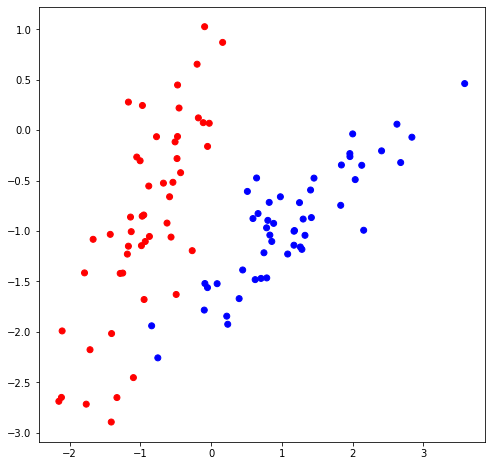

In [4]:
# Визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(classification_data[:,0], classification_data[:,1], c=classification_labels, cmap=colors)
plt.show()

In [5]:
# Получение N бутстрап-выборок

def get_bootstrap(data, labels, N):
    random.seed(10)
    
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):        
        sample_indexes = [random.randint(0, n_samples-1) for _ in range(n_samples)]
        bootstrap.append((data[sample_indexes], labels[sample_indexes]))
        
    return bootstrap

In [6]:
# Получение индексов подмножества признаков. Для задачи классификации число признаков берём sqrt(n).

def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    random.shuffle(sample_indexes)

    len_subsample = int(np.sqrt(len_sample))
    subsample = sample_indexes[0:len_subsample].copy()
        
    return subsample

In [7]:
# Класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [8]:
# Класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [9]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [10]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [11]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [12]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]

    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_gini)
                        
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [13]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [14]:
# Формирование случайного леса

def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [15]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [17]:
# Предсказание по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [18]:
# Предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев        
    voted_predictions = [max(set(obj), key=obj.count) for obj in predictions_per_object]
    

    return voted_predictions

In [19]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [20]:
# Методы для визуализации данных и дерева на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def draw_dataset(train_data, train_labels, test_data, test_labels, forest):
    plt.figure(figsize = (10, 4))

    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

    # график обучающей выборки
    plt.subplot(1,2,1)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title('Обучающая выборка')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title('Тестовая выборка')

    plt.show()

In [21]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    classification_data, 
    classification_labels,
    test_size = 0.3,
    random_state = 1
)


Число деревьев в случайном лесе: 	1
Точность обучающей выборки: 	92.85714285714286
Точность тестовой выборки: 	96.66666666666667


<ipython-input-20-7a1548834145>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-20-7a1548834145>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


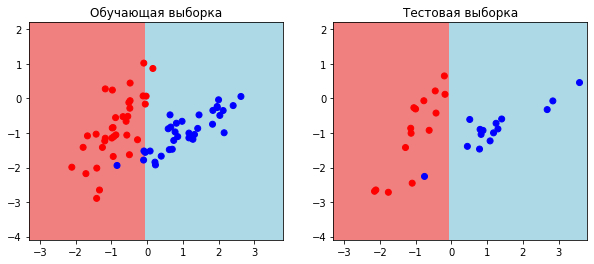


Число деревьев в случайном лесе: 	3
Точность обучающей выборки: 	94.28571428571428
Точность тестовой выборки: 	96.66666666666667


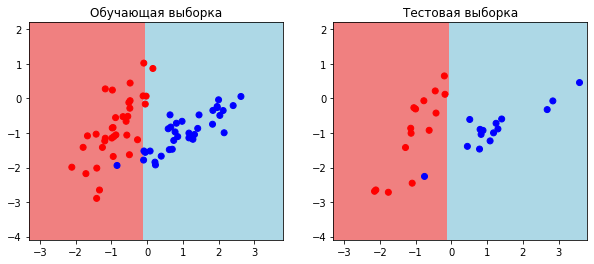


Число деревьев в случайном лесе: 	10
Точность обучающей выборки: 	97.14285714285714
Точность тестовой выборки: 	96.66666666666667


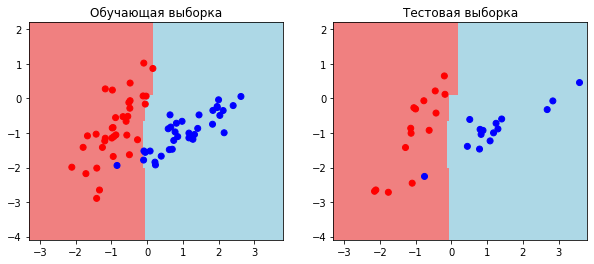


Число деревьев в случайном лесе: 	50
Точность обучающей выборки: 	98.57142857142858
Точность тестовой выборки: 	96.66666666666667


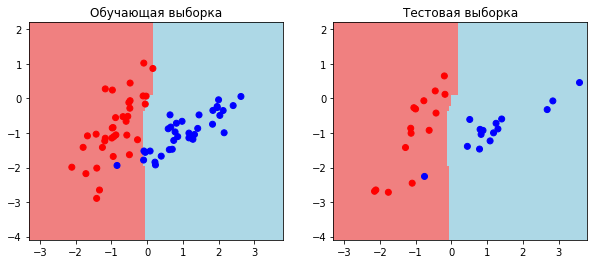

In [22]:
for n_trees in [1, 3, 10, 50]:
    # обучение
    my_forest = random_forest(train_data, train_labels, n_trees)

    # предсказание
    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data)

    # параметры точности
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)

    print(f'\nЧисло деревьев в случайном лесе: \t{n_trees}\nТочность обучающей выборки: \t{train_accuracy}\nТочность тестовой выборки: \t{test_accuracy}')

    draw_dataset(train_data, train_labels, test_data, test_labels, my_forest)

2.Сделайте выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нём

Чем больше число деревьев в случайном лесе, тем выше точность на обучающей выборке и тем сложнее разделяющая гиперплоскость. Но при этом точность на тестовой выборке меняется не сильно. Модель случайного леса не подвержена переобучению. В теории ошибка предсказания обратно пропорциональна количестиву деревьев в случайном лесе.

3.Замените в реализованном алгоритме проверку, используя отложенную выборку на Out-of-Bag.

Переопределим метод получения бутстрап-выборки get_bootstrap таким образом, чтобы он возвращал ещё и отложенную выборку. Учтем это в методе построения случайного леса random_forest. Это метод сразу будет вычислять out_of_bag_score по данным, не входящим в бутстрап-выборки.

In [23]:
# Получение N бутстрап-выборок и N массивов индексов данных, которые входят в соответствующую бутстрап-выборку.

def get_bootstrap(data, labels, N):
    random.seed(10)

    n_samples = data.shape[0]
    bootstrap = []
    b_indexes = []

    for i in range(N):        
        sample_indexes = [random.randint(0, n_samples-1) for _ in range(n_samples)]
        bootstrap.append((data[sample_indexes], labels[sample_indexes]))
        b_indexes.append(sample_indexes)
        
    return bootstrap, b_indexes

In [24]:
# Метрика точности для данных, не входящих в бутстрап-выборки 

def out_of_bag_score(data, labels, b_indexes, forest):
    predictions = []
    actual = []

    # перебираем все имеющиеся данные 
    for i in range(data.shape[0]):

        # индексы деревьев, которые не обучались на текущем наблюдении
        index_tree = [] 
        for idx, b_index in enumerate(b_indexes):
            if i not in b_index: 
                index_tree.append(idx)

        if len(index_tree) != 0:
            new_forest = [forest[k] for k in index_tree] # новый лес на деревьях, которые не обучались на текущем наблюдении
            predictions.append(tree_vote(new_forest, [data[i]])[0]) # предсказание по текущему наблюдению
            actual.append(labels[i]) # истинное значение класса текущего наблюдения

    return accuracy_metric(actual, predictions)

In [25]:
# Формирование случайного леса

def random_forest(data, labels, n_trees):
    forest = []
    bootstrap, b_indexes = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
    
    # считаем ошибку по данным, не входящим в бутстрап-выборки 
    oob_score = out_of_bag_score(data, labels, b_indexes, forest)

    return forest, oob_score

In [26]:
n_trees_arr = np.arange(1, 51, 1)
oob_scores = []

for n_trees in n_trees_arr:
    _, oob_score = random_forest(classification_data, classification_labels, n_trees)
    oob_scores.append(oob_score)

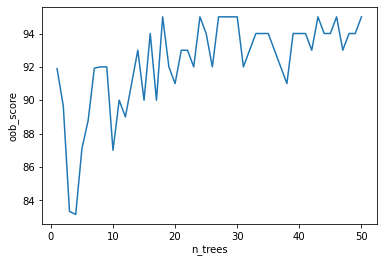

In [27]:
plt.plot(n_trees_arr, oob_scores)
plt.xlabel('n_trees')
plt.ylabel('oob_score')
plt.show()

4.(На повторение) Перепишите функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шеннона. Переименуйте функцию в calc_entropy.

Индекс Джини:
$$H(X) = \sum_{k=1}^K p_k(1 - p_k)$$

Энтропия Шеннона:
$$H(X) = -\sum_{k=1}^K p_k\log_2p_k$$

Дисперсионный критерий:
$$H(X) = \frac{1}{X}\sum_{i\in{X}}(y_i - \overline{y}(X))^2$$

Дисперсионный критерий используется в задачах регрессии, критерий Джени и энтропийный критерий Шеннона используются в задачах классификации. 

In [28]:
# Расчет энтропийного критерия Шеннона

def calc_entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0    
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)
        
    return impurity

Переопределим метод вычисления функционала качества и метод нахождения наилучшего разбиения так, чтобы они использовали энтропийный критерий Шеннона в качестве критерия информативности.

In [29]:
# Расчет качества с использованием энтропии Шеннона

def quality(left_labels, right_labels, current_entropy):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * calc_entropy(left_labels) - (1 - p) * calc_entropy(right_labels)

In [30]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_entropy = calc_entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]

    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_entropy)
                        
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [31]:
oob_scores_2 = []

for n_trees in n_trees_arr:
    _, oob_score = random_forest(classification_data, classification_labels, n_trees)
    oob_scores_2.append(oob_score)

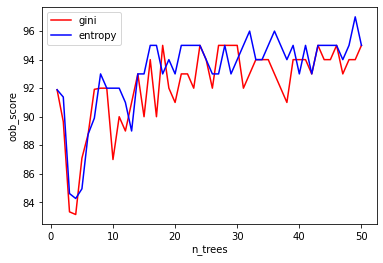

In [32]:
plt.plot(n_trees_arr, oob_scores, c='r')
plt.plot(n_trees_arr, oob_scores_2, c='b')
plt.legend(['gini', 'entropy'])
plt.xlabel('n_trees')
plt.ylabel('oob_score')
plt.show()

Разница в использовании в качестве критерия информативности критерия Джини и энтропийного критерия Шеннона не существенна.